In [5]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [6]:
api_wrapper_arvix=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arvix=ArxivQueryRun(api_wrapper=api_wrapper_arvix)
print(arvix.name)

arxiv


In [7]:
arvix.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [8]:
wiki_wrapper_arvix=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wikipedia=WikipediaQueryRun(api_wrapper=wiki_wrapper_arvix)
print(wikipedia.name)

wikipedia


In [9]:
wikipedia.invoke("What is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [10]:
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['TAVILY_API_KEY']=os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
os.environ['LANGCHAIN_API_KEY']=os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_PROJECT']="ReAct-agent"

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

In [13]:
def multiply(a:int,b:int)->int:
    """
    Multiply a and b
    Args:
        a (int): First number
        b (int): Second number
    Returns:
        int: Product of a and b
    """
    return a*b

In [14]:
def add(a:int,b:int)->int:
    """Add two numbers"""
    return a+b

In [15]:
def divide(a:int,b:int)->int:
    """Divide function"""
    return a/b

In [17]:
tools=[arvix,wikipedia,tavily,add,multiply,divide]

In [18]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-120b")
llm_with_tools=llm.bind_tools(tools)

In [19]:
llm_with_tools=llm.bind_tools(tools) 

In [22]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])


AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "What is the recent AI News". They likely want a summary of recent AI news. Need to browse up-to-date info. Use tavily_search_results_json with query "recent AI news 2024".', 'tool_calls': [{'id': 'fc_4b199782-5d18-4bc4-88fa-f744566939fe', 'function': {'arguments': '{"query":"recent AI news 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 389, 'total_tokens': 472, 'completion_time': 0.184034515, 'completion_tokens_details': {'reasoning_tokens': 47}, 'prompt_time': 0.020365008, 'prompt_tokens_details': None, 'queue_time': 0.049926442, 'total_time': 0.204399523}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_d29d1d1418', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bee7c-4e93-7c13-9fde-e5defcb84037-0', tool_calls=[{'name': 

In [23]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'AI news January 2026'},
  'id': 'fc_e9ed860b-df6a-4360-a1bd-7f6e844ebe9a',
  'type': 'tool_call'}]

In [28]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [29]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [39]:
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
def tool_calling_llm(state:State):
    return {"messages":llm_with_tools.invoke(state['messages'])}
    

In [40]:
builder=StateGraph(State)

In [41]:
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)


builder.add_edge("tools","tool_calling_llm")


In [42]:
graph=builder.compile()


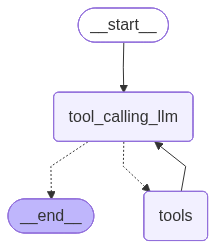

In [43]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent news related to AI")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent news related to AI
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_415abc57-05b8-400c-86af-6a1465cb13f5)
 Call ID: fc_415abc57-05b8-400c-86af-6a1465cb13f5
  Args:
    query: latest AI news 2024
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Your AI Update - January 2024 | News", "url": "https://altech.nd.edu/events-news/news/your-ai-update-january-2024/", "content": "a market-challenging AI chatbot developed by Microsoft that is intended to be integrated into the Microsoft 365 suite of products. Initially launched last February as ‘Bing Chat,’ the product has undergone many changes on its way to being Microsoft’s flagship AI product. Similarly, Google is integrating its Quantum technologies into its Chrome browser and ad 

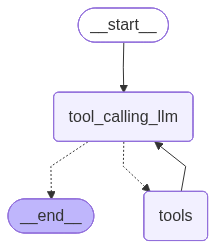

In [48]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory=builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
config={"configuration":{"thread_id":"1"}}
messages=[HumanMessage(content="Add 12 and 11")]
messages=graph.invoke({"messages":messages},config=config )
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 11
================================== Ai Message ==================================
Tool Calls:
  add (fc_c24b8af1-c07d-4906-ac5f-075de39ad987)
 Call ID: fc_c24b8af1-c07d-4906-ac5f-075de39ad987
  Args:
    a: 12
    b: 11
================================= Tool Message =================================
Name: add

23
================================== Ai Message ==================================

23
